# Train-Holdout Sequential Synthesis Testing

This notebook performs the synthesis using our proposed synthesization approach for the training data only (excludes the holdout data).

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from sklearn.mixture import GaussianMixture
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier

import itertools

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures

from bayesian_bootstrap import bayesian_bootstrap

rng = np.random.RandomState(42)

In [2]:
def cart_pmse_ratio(original_data, synthetic_data_sets):
    
    ### get pmse measures for synthetic data set pairs
    
    null_pmse_list = []
    
    inds = np.arange(len(synthetic_data_sets))
    
    combo_list = list(itertools.combinations(inds, 2))
    
    for combo in combo_list:
    
        s1 = synthetic_data_sets[combo[0]]
        s2 = synthetic_data_sets[combo[1]]
    
        N_orig = s1.shape[0]
        N_synth = s2.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([s1, s2], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        null_pmse_list.append(pMSE)
    
    pmse_list = []
    
    for s in synthetic_data_sets:
    
        N_orig = original_data.shape[0]
        N_synth = s.shape[0]
    
        c = N_synth/(N_synth+N_orig)
    
        full_X = pd.concat([original_data, s], axis=0).reset_index(drop=True)
    
        full_X = preprocessing.StandardScaler().fit_transform(full_X)

        y = np.repeat([0, 1], repeats=[N_orig, N_synth])
    
        cart = DecisionTreeClassifier(min_samples_split=20,
                                      min_samples_leaf=int(np.round(20/3)),
                                      ccp_alpha=0.0001,
                                      max_depth=30)
    
        cart.fit(X=full_X, y=y)
    
        probs = cart.predict_proba(full_X)
    
        pMSE = 1/(N_synth + N_orig) * np.sum((probs[:,1] - c)**2)
        
        pmse_list.append(pMSE)
    
    return np.array(pmse_list)/(np.mean(null_pmse_list))

Import the data.

In [3]:
# import standardized lat/long location data
X = pd.read_csv("Data/cleaned_data.csv")

Number of locations from deceased individuals.

In [4]:
np.sum(X.state)

55

Split dataset into continuous and categorical variables.

In [5]:
X

,latitude,longitude,sex,age,state
0,0.944157,-1.010655,male,50s,0
1,0.889746,-0.694899,male,50s,0
2,0.917482,-0.682299,male,30s,0
3,0.916660,-0.682551,male,30s,0
4,0.886074,-0.668883,male,30s,0
...,...,...,...,...,...
6707,0.881500,-0.925307,male,40s,0
6708,-1.728784,1.470871,male,40s,0
6709,-1.548071,1.557316,male,40s,0
6710,-1.549392,1.555785,male,40s,0


In [6]:
cat_columns = X.select_dtypes(['object']).columns

In [7]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.astype('category'))

In [8]:
categories = X[cat_columns].apply(lambda x: x.cat.categories)

In [9]:
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)

In [10]:
categories

sex            Index(['female', 'male'], dtype='object')
age    Index(['0s', '10s', '20s', '30s', '40s', '50s'...
dtype: object

In [11]:
np.mean(X.sex)

0.4620083432657926

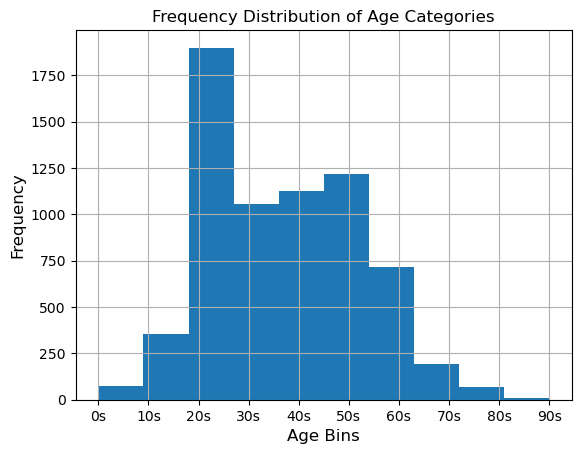

In [12]:
ax = X.age.plot.hist(grid=True, bins=10)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Age Bins', fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(labels=categories['age'])
plt.title("Frequency Distribution of Age Categories")
plt.show()

***

Create and save the training and holdout datasets.

In [13]:
shuffle_X = X.sample(frac=1.0, random_state=42).reset_index(drop=True)

half = int(np.ceil(shuffle_X.shape[0]/2))

train_data = shuffle_X.iloc[:half,:]
holdout_data = shuffle_X.iloc[half:,:]

In [14]:
train_data.to_csv("Data/synthetic_datasets/train_dataset.csv", index=False)
holdout_data.to_csv("Data/synthetic_datasets/holdout_dataset.csv", index=False)

***

Testing logistic and multinomial logistic regression synthesizers.

In [15]:
def polynomial_and_standardize(dataset, poly_degree=3, interaction_only=False):
    
    poly = PolynomialFeatures(degree=poly_degree, interaction_only=interaction_only, include_bias=False)
    
    X = poly.fit_transform(dataset)
    
    scaled_X = preprocessing.StandardScaler().fit_transform(X)
    
    return scaled_X

In [16]:
def multinomial_synthesizer(orig_data, synth_data_sets, target, penalty_param, poly_degree=3, interaction_only=False):
    
    mn_model = LogisticRegression(penalty='l1', C=penalty_param, solver='saga', max_iter=1000, multi_class='multinomial', random_state=rng)
    
    X = polynomial_and_standardize(dataset=orig_data, poly_degree=poly_degree, interaction_only=interaction_only)
    
    sXs = [polynomial_and_standardize(dataset=Y, poly_degree=poly_degree, interaction_only=interaction_only) for Y in synth_data_sets]
    
    vals = []
    
    mn_model.fit(X, target)
    
    rng_mn = default_rng()
    
    for Y in sXs:
        
        probs = mn_model.predict_proba(Y)
    
        v = [np.argmax(rng_mn.multinomial(n=1, pvals=p, size=1)==1) for p in probs]
    
        vals.append(pd.Series(v, name=target.name))
    
    return vals

In [17]:
def train_models_mn(#overall parameters
                    train_data,
                    number_synthetic_datasets,
                    # hyperparameters for GMM, end with underscore means Bayesian optimization will choose
                    number_gmm_initializations,
                    num_components_,
                    # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                    C_sex_,
                    C_age_,
                    C_state_):
    
    num_samples = train_data.shape[0]
    
    ########## Code for GMM ############
    
    # fit GMM model
    GMM = GaussianMixture(num_components_, n_init=number_gmm_initializations, init_params="k-means++", random_state=rng).fit(train_data.loc[:,["latitude", "longitude"]])
    
    # list for synthetic datasets
    sXs = []
    
    # generate and store number_synthetic_datasets synthetic datasets
    for i in range(number_synthetic_datasets):
        sX = GMM.sample(num_samples)[0]
        sX = pd.DataFrame(sX)
        sX.columns = ['latitude', 'longitude']
        sXs.append(sX)
        
    ####################################################################################################
        
    ########### Code for sex MN ##########
    
    synth_sex_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.sex, 
                                             penalty_param=C_sex_)
    
    sXs = [pd.concat([Y, synth_sex_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
        
    ########### Code for age MN ##########
    
    synth_age_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex"]], 
                                             synth_data_sets=sXs, 
                                             target=train_data.age, 
                                             penalty_param=C_age_)
    
    sXs = [pd.concat([Y, synth_age_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ####################################################################################################
    
    ########### Code for state MN ##########
    
    synth_state_vars = multinomial_synthesizer(orig_data=train_data.loc[:,["latitude", "longitude", "sex", "age"]], 
                                               synth_data_sets=sXs, 
                                               target=train_data.state, 
                                               penalty_param=C_state_)
    
    sXs = [pd.concat([Y, synth_state_vars[i]], axis=1) for i,Y in enumerate(sXs)]
        
    ###### Calculate pMSE ratios ######
    # pmse_ratios = [pmse_ratio(train_data, Y) for Y in sXs]
    pmse_ratios = cart_pmse_ratio(train_data, sXs)
    
    return pmse_ratios, sXs, GMM

In [18]:
def optimize_models_mn(train_data,
                       number_synthetic_datasets,
                       number_gmm_initializations,
                       random_state):

    def evaluate_models(num_components_, C_sex_, C_age_, C_state_):

        pmse_ratios, _, _ = train_models_mn(train_data=train_data,
                                            number_synthetic_datasets=number_synthetic_datasets,
                                            number_gmm_initializations=number_gmm_initializations,
                                            num_components_=int(num_components_),
                                            C_sex_=C_sex_,
                                            C_age_=C_age_,
                                            C_state_=C_state_)
        
        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "num_components_": (200, 800.99),
            "C_sex_": (0.001, 1),
            "C_age_": (0.001, 1),
            "C_state_": (0.001, 1)
        },
        random_state=random_state)
    
    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.set_gp_params(alpha=1e-3)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value for $\alpha = 1e-06$.

In [19]:
nsd = 20
ngi = 5
random_states = [np.random.RandomState(1234), np.random.RandomState(4321), np.random.RandomState(10620), np.random.RandomState(91695), np.random.RandomState(31296)]
# random_states = [np.random.RandomState(1234)]

In [20]:
optimization_results = [optimize_models_mn(train_data=train_data, number_synthetic_datasets=nsd, number_gmm_initializations=ngi, random_state=r) for r in random_states]

|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.175    | 0.1923    | 0.6225    | 0.4383    | 672.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.162    | 0.7802    | 0.2733    | 0.2772    | 681.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 3         | -0.07297  | 0.9582    | 0.8761    | 0.3585    | 501.1     |
| 4         | -0.09751  | 0.6838    | 0.713     | 0.3709    | 537.3     |
| 5         | -0.2903   | 0.5036    | 0.01475   | 0.7731    | 730.5     |
| 6         | -0.1347   | 0.1397    | 0.2696    | 0.5198    | 473.5     |
| 7         | -0.1027   | 0.1671    | 0.3357    | 0.7734    | 515.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 8         | -0.087    | 0.7666    | 0.5234    | 0.01921   | 568.4     |
| 9         | -0.0952   | 0.7056    | 0.7798    | 0.1143    | 500.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.1352   | 1.0       | 1.0       | 1.0       | 503.3     |
| 11        | -0.03408  | 0.1999    | 0.7286    | 0.5743    | 566.5     |
| 12        | -0.08084  | 0.5658    | 0.1931    | 0.7402    | 565.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.1262   | 0.8594    | 0.8769    | 0.9633    | 566.8     |
| 14        | -0.1717   | 0.04245   | 0.6952    | 0.08167   | 566.3     |
| 15        | -0.06674  | 0.4989    | 0.4481    | 0.1825    | 746.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 16        | -0.1113   | 0.9616    | 0.2925    | 0.3235    | 558.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.08726  | 0.8955    | 0.8985    | 0.993     | 596.1     |
| 18        | -0.1258   | 0.2376    | 0.6633    | 0.003517  | 688.6     |
| 19        | -0.08293  | 0.3132    | 0.9325    | 0.6337    | 283.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.06629  | 0.9792    | 0.9668    | 0.8903    | 650.3     |
| 21        | -0.1112   | 0.5032    | 0.1146    | 0.8056    | 683.9     |
| 22        | -0.105    | 0.1857    | 0.9014    | 0.9542    | 571.6     |
| 23        | -0.1346   | 0.754     | 0.4819    | 0.7481    | 623.2     |
| 24        | -0.149    | 0.127     | 0.1221    | 0.8523    | 456.2     |
| 25        | -0.2237   | 0.004964  | 0.6289    | 0.2232    | 620.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 26        | -0.1157   | 0.8436    | 0.7555    | 0.2184    | 350.2     |
| 27        | -0.24     | 0.3828    | 0.9658    | 0.57      | 600.3     |
| 28        | -0.1629   | 0.6641    | 0.2081    | 0.1172    | 239.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.07484  | 0.9084    | 0.8579    | 0.3945    | 252.6     |
| 30        | -0.2364   | 0.7432    | 0.8908    | 0.2181    | 764.5     |
Final Result:  {'target': -0.034081503359432684, 'params': {'C_age_': 0.19988631255681988, 'C_sex_': 0.7286429381291926, 'C_state_': 0.5742801653328341, 'num_components_': 566.4773951829357}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.265    | 0.07173   | 0.8152    | 0.7681    | 372.1     |
| 2         | -0.1904   | 0.1939    | 0.9789    | 0.4068    | 655.4     |
| 3         | -0.07311  | 0.09006   | 0.3106    | 0.6193    | 476.4     |
| 4         | -0.2399   | 0.2191    | 0.6639    | 0.679     | 771.1     |
| 5         | -0.1117   | 0.282     | 0.6202    | 0.3839    | 440.6     |
| 6         | -0.0636   | 0.579     | 0.5145    | 0.2766    | 476.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.187    | 0.9815    | 0.3175    | 0.172     | 470.2     |
| 8         | -0.09575  | 0.6021    | 0.7746    | 0.03279   | 478.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1227   | 0.9534    | 0.08231   | 0.1369    | 434.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.1182   | 0.8202    | 0.0812    | 0.8516    | 447.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.0612   | 0.3796    | 0.9378    | 0.9773    | 454.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.287    | 0.001     | 0.001     | 1.0       | 457.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.08494  | 0.9318    | 0.7271    | 0.8207    | 453.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.09629  | 0.985     | 0.7793    | 0.85      | 476.7     |
| 15        | -0.1014   | 0.2038    | 0.06716   | 0.03994   | 475.1     |
| 16        | -0.1532   | 0.5023    | 0.1987    | 0.05502   | 477.1     |
| 17        | -0.1157   | 0.006434  | 0.9177    | 0.6291    | 475.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.1168   | 0.8787    | 0.1915    | 0.7876    | 475.8     |
| 19        | -0.07031  | 0.3173    | 0.1996    | 0.6312    | 453.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 20        | -0.109    | 0.802     | 0.7002    | 0.1214    | 454.2     |
| 21        | -0.2298   | 0.0755    | 0.9374    | 0.8735    | 453.3     |
| 22        | -0.0386   | 0.407     | 0.3242    | 0.09901   | 285.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.09896  | 0.8552    | 0.6589    | 0.1512    | 454.3     |
| 24        | -0.1016   | 0.7296    | 0.4853    | 0.7711    | 454.3     |
| 25        | -0.02962  | 0.3324    | 0.7969    | 0.4568    | 356.3     |
| 26        | -0.1191   | 0.358     | 0.8278    | 0.4643    | 356.6     |
| 27        | -0.1105   | 0.3668    | 0.08044   | 0.2743    | 515.6     |
| 28        | -0.005236 | 0.2165    | 0.5258    | 0.5643    | 355.9     |
| 29        | -0.1875   | 0.7127    | 0.5375    | 0.2854    | 476.3     |
| 30        | -0.06532  | 0.7419    | 0.2986    | 0.9169    | 676.4     |
Final Result:  {'target': -0.005235904319304478, 'params': {'C_age_': 0.21649159563989606, 'C_sex_': 0.5257502535571056, 'C_state_': 0.5643219262073985, 'num_components_': 355.93257315595804}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------
| 1         | -0.02856  | 0.5169    | 0.3209    | 0.169     | 231.5

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.1693   | 0.9317    | 0.05982   | 0.4362    | 214.9     |
| 3         | -0.1062   | 0.492     | 0.7016    | 0.7721    | 441.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 4         | -0.04649  | 0.9199    | 0.5447    | 0.6874    | 348.1     |
| 5         | -0.03455  | 0.245     | 0.5641    | 0.2667    | 341.4     |
| 6         | -0.04216  | 0.06747   | 0.4695    | 0.2264    | 237.3     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 7         | -0.03851  | 0.9808    | 0.5949    | 0.6017    | 331.1     |
| 8         | -0.03776  | 0.07341   | 0.8619    | 0.07036   | 317.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1432   | 0.8778    | 0.02438   | 0.647     | 303.9     |
| 10        | -0.2141   | 0.02197   | 0.007249  | 0.1545    | 323.4     |
| 11        | -0.06514  | 0.4437    | 0.3217    | 0.1569    | 232.6     |
| 12        | -0.03839  | 0.5152    | 0.4379    | 0.2176    | 230.0     |
| 13        | -0.08352  | 0.4958    | 0.5621    | 0.4214    | 343.9     |
| 14        | -0.1371   | 0.04404   | 0.3105    | 0.5503    | 339.4     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.1295   | 0.8554    | 0.8029    | 0.9306    | 231.1     |
| 16        | -0.02251  | 0.2099    | 0.8405    | 0.06698   | 281.0     |
| 17        | -0.1167   | 0.5313    | 0.06141   | 0.001019  | 452.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 18        | -0.07269  | 0.7777    | 0.8424    | 0.6244    | 413.5     |
| 19        | -0.02595  | 0.4622    | 0.62      | 0.7901    | 670.1     |
| 20        | -0.0927   | 0.5465    | 0.2111    | 0.8136    | 791.3     |
| 21        | -0.1351   | 0.1025    | 0.7153    | 0.627     | 458.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.09924  | 0.9625    | 0.1834    | 0.4484    | 774.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 23        | -0.09421  | 0.9719    | 0.99      | 0.3031    | 527.0     |
| 24        | -0.09809  | 0.07692   | 0.4378    | 0.7962    | 254.5     |
| 25        | -0.1712   | 0.1397    | 0.2114    | 0.167     | 708.4     |
| 26        | -0.2058   | 0.3783    | 0.2654    | 0.5825    | 586.5     |
| 27        | -0.07382  | 0.6913    | 0.8035    | 0.01801   | 566.1     |
| 28        | -0.08675  | 0.7095    | 0.817     | 0.2824    | 294.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 29        | -0.1062   | 0.2265    | 0.3821    | 0.9755    | 786.9     |
| 30        | -0.142    | 0.1747    | 0.2322    | 0.8206    | 769.2     |
Final Result:  {'target': -0.022509662984592182, 'params': {'C_age_': 0.20989439493256928, 'C_sex_': 0.8405201625722261, 'C_state_': 0.06697872737053201, 'num_components_': 280.950343153157}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
-------------------------------------------------------------------------


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.08551  | 0.9739    | 0.9884    | 0.3971    | 547.1     |
| 2         | -0.04014  | 0.5583    | 0.3046    | 0.6306    | 280.9     |
| 3         | -0.09668  | 0.5341    | 0.7397    | 0.9104    | 416.8     |
| 4         | -0.16     | 0.0451    | 0.8073    | 0.6553    | 560.9     |
| 5         | -0.03026  | 0.5853    | 0.1652    | 0.8145    | 541.5     |
| 6         | -0.07727  | 0.2255    | 0.6396    | 0.3699    | 653.6     |
| 7         | -0.1335   | 0.1253    | 0.3416    | 0.8001    | 220.5     |
| 8         | -0.08941  | 0.3601    | 0.5363    | 0.9231    | 539.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 9         | -0.1118   | 0.9583    | 0.8795    | 0.9924    | 756.7     |
| 10        | -0.1407   | 0.3566    | 0.587     | 0.5041    | 541.6     |
| 11        | -0.1296   | 0.5369    | 0.05338   | 0.3515    | 592.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.09733  | 0.7815    | 0.7021    | 0.676     | 792.6     |
| 13        | -0.03472  | 0.3699    | 0.07209   | 0.6298    | 373.3     |
| 14        | -0.1698   | 0.4764    | 0.5064    | 0.4547    | 752.2     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 15        | -0.1644   | 0.8298    | 0.6411    | 0.3829    | 678.0     |
| 16        | -0.1099   | 0.4114    | 0.258     | 0.6106    | 726.3     |
| 17        | -0.1047   | 0.5998    | 0.3643    | 0.219     | 279.2     |
| 18        | -0.2071   | 0.3757    | 0.1069    | 0.7331    | 280.2     |
| 19        | -0.1169   | 0.4471    | 0.3043    | 0.1821    | 245.2     |
| 20        | -0.1775   | 0.1895    | 0.1163    | 0.6402    | 777.7     |
| 21        | -0.1005   | 0.6051    | 0.2016    | 0.5203    | 290.6     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 22        | -0.1316   | 0.849     | 0.4886    | 0.4297    | 693.0     |
| 23        | -0.1622   | 0.1495    | 0.1934    | 0.4371    | 757.1     |
| 24        | -0.09648  | 0.3496    | 0.006242  | 0.5401    | 605.6     |
| 25        | -0.09183  | 0.6368    | 0.322     | 0.471     | 532.3     |
| 26        | -0.13     | 0.01439   | 0.03077   | 0.5383    | 293.5     |
| 27        | -0.1298   | 0.6735    | 0.9049    | 0.2768    | 495.0     |
| 28        | -0.04226  | 0.6343    | 0.1396    | 0.1141    | 634.0     |
| 29        | -0.07463  | 0.6899    | 0.6846    | 0.6874    | 345.0     |
| 30        | -0.1942   | 0.5079    | 0.1486    | 0.3773    | 562.1     |
Final Result:  {'target': -0.030260286930059, 'params': {'C_age_': 0.5853360317592435, 'C_sex_': 0.1651508583115951, 'C_state_': 0.8145459281054448, 'num_components_': 541.4940392388362}}
|   iter    |  target   |  C_age_   |  C_sex_   | C_state_  | num_co... |
------------------------------------------------------------------------

C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 1         | -0.01808  | 0.8661    | 0.3078    | 0.8155    | 253.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 2         | -0.04145  | 0.8067    | 0.7034    | 0.01835   | 341.2     |
| 3         | -0.132    | 0.2013    | 0.4947    | 0.2976    | 749.8     |
| 4         | -0.1534   | 0.6772    | 0.3474    | 0.11      | 743.9     |
| 5         | -0.1017   | 0.3711    | 0.1981    | 0.9662    | 360.8     |
| 6         | -0.0393   | 0.4288    | 0.2492    | 0.4031    | 264.3     |
| 7         | -0.1262   | 0.06129   | 0.4726    | 0.003015  | 237.9     |
| 8         | -0.04243  | 0.008834  | 0.1002    | 0.9458    | 257.5     |
| 9         | -0.0546   | 0.5917    | 0.9606    | 0.09615   | 249.8     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 10        | -0.08104  | 0.8878    | 0.7475    | 0.007683  | 271.9     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 11        | -0.09727  | 1.0       | 0.8243    | 0.001     | 333.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 12        | -0.07128  | 0.7936    | 0.9758    | 0.9052    | 347.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 13        | -0.1109   | 0.9496    | 0.1697    | 0.547     | 487.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 14        | -0.2929   | 0.672     | 0.7386    | 0.9717    | 594.1     |
| 15        | -0.1656   | 0.6273    | 0.8147    | 0.8685    | 420.9     |
| 16        | -0.2031   | 0.2629    | 0.05276   | 0.009704  | 671.5     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 17        | -0.3573   | 0.02479   | 0.5443    | 0.9925    | 783.4     |
| 18        | -0.1357   | 0.001     | 0.05617   | 0.001     | 382.4     |
| 19        | -0.08613  | 0.2592    | 0.5749    | 0.05858   | 512.3     |
| 20        | -0.07645  | 0.2697    | 0.7246    | 0.4353    | 529.8     |
| 21        | -0.06416  | 0.447     | 0.1434    | 0.7866    | 546.1     |
| 22        | -0.05014  | 0.7206    | 0.4769    | 0.001     | 559.2     |
| 23        | -0.1821   | 0.6299    | 0.1812    | 0.589     | 200.0     |
| 24        | -0.156    | 0.2078    | 0.2469    | 0.2571    | 461.1     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 25        | -0.0652   | 0.794     | 0.1962    | 0.9237    | 299.9     |
| 26        | -0.1112   | 0.01016   | 0.1719    | 0.1465    | 311.7     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 27        | -0.5371   | 0.001     | 0.001     | 1.0       | 289.0     |


C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Cameron\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


| 28        | -0.1235   | 0.8071    | 0.8574    | 0.9754    | 304.2     |
| 29        | -0.09232  | 0.3131    | 0.6671    | 0.8614    | 553.1     |
| 30        | -0.1061   | 0.1508    | 0.401     | 0.1019    | 538.5     |
Final Result:  {'target': -0.018082189164369183, 'params': {'C_age_': 0.8660559210897837, 'C_sex_': 0.30776040317146436, 'C_state_': 0.8154757090152275, 'num_components_': 253.457271051029}}


In [21]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

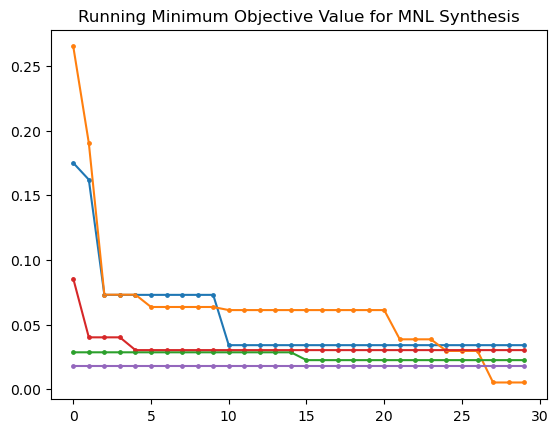

In [22]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.plot(run_targets[2])
plt.scatter(np.arange(len(run_targets[2])), run_targets[2], s=6)
plt.plot(run_targets[3])
plt.scatter(np.arange(len(run_targets[3])), run_targets[3], s=6)
plt.plot(run_targets[4])
plt.scatter(np.arange(len(run_targets[4])), run_targets[4], s=6)
plt.title("Running Minimum Objective Value for MNL Synthesis")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [23]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [24]:
best_params

{'target': -0.005235904319304478,
 'params': {'C_age_': 0.21649159563989606,
  'C_sex_': 0.5257502535571056,
  'C_state_': 0.5643219262073985,
  'num_components_': 355.93257315595804}}

Generate 20 synthetic data sets.

In [25]:
full_ratios, full_sXs, GMM = train_models_mn(train_data=train_data,
                                             number_synthetic_datasets=20,
                                             # hyperparameters for GMM
                                             number_gmm_initializations=ngi,
                                             num_components_=int(best_params['params']['num_components_']),
                                             # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                                             C_sex_=best_params['params']['C_sex_'],
                                             C_age_=best_params['params']['C_age_'],
                                             C_state_=best_params['params']['C_state_'])

In [26]:
(1 - np.mean(full_ratios))**2

0.07221273888365107

In [27]:
np.mean(full_ratios)

1.2687242804133096

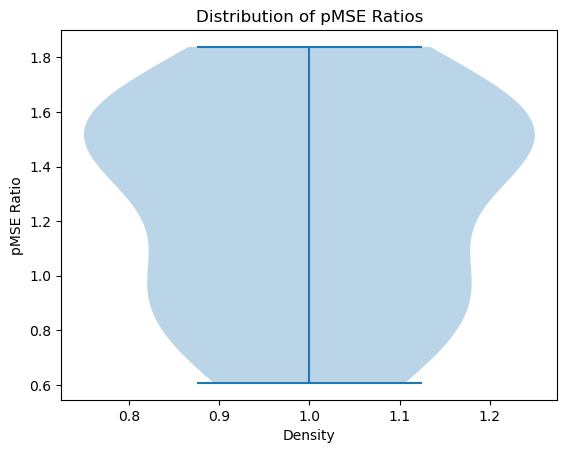

In [28]:
plt.violinplot(full_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

# Save the synthetic datasets.

In [29]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("Data/synthetic_datasets/logistic_cart_synthetic_dataset_" + str(i) + ".csv", index=False)

***